In [1]:
from glob import glob
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import json
from statsmodels.stats.multitest import multipletests
from goatools.test_data.genes_NCBI_9606_All import GENEID2NT
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.obo_parser import GODag
from goatools.godag_obosm import OboToGoDagSmall
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
meta = pd.read_csv('meta.csv',index_col=0)

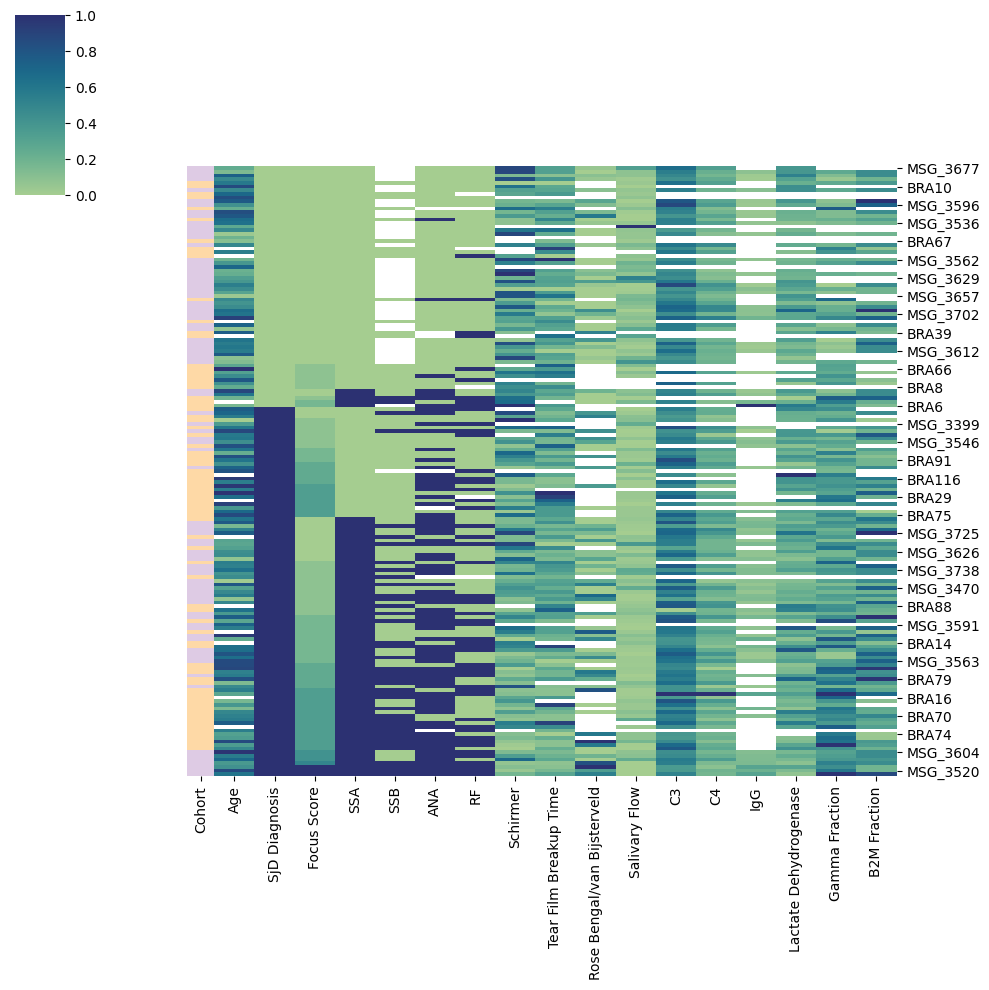

In [14]:
hm = meta.drop('Cohort',axis=1)
hm = hm.replace('Positive',1).replace('Negative',0)
hm = (hm - hm.min()) / (hm.max() - hm.min())
hm = hm.sort_values(['SjD Diagnosis','SSA','Focus Score'])
row_colors = meta['Cohort'].replace('BRA','#fed9a6').replace('MSG','#decbe4')[hm.index]
sns.clustermap(hm,row_cluster=False,col_cluster=False,cmap='crest',row_colors=row_colors)
plt.savefig('figures/heatmap.pdf',format='pdf',bbox_inches='tight')

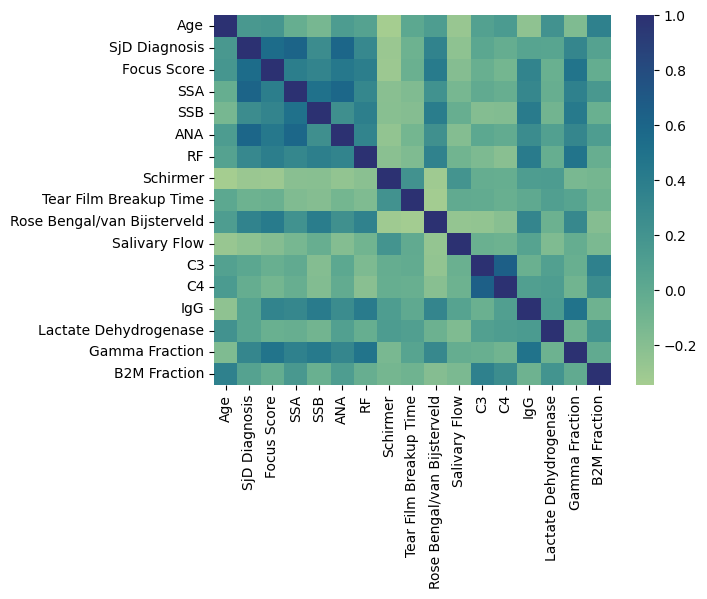

In [15]:
sns.heatmap(hm.corr(),cmap='crest')
plt.savefig('figures/corr.pdf',format='pdf',bbox_inches='tight')

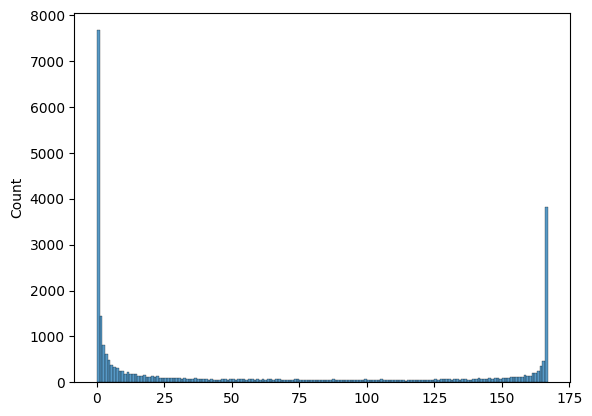

In [59]:
CPM = pd.read_csv('all_gene.csv',index_col=0)
genes = (CPM == 0).sum(axis=1)
sns.histplot(genes,binwidth=1)
plt.show()

[0.8551107  0.07773574]


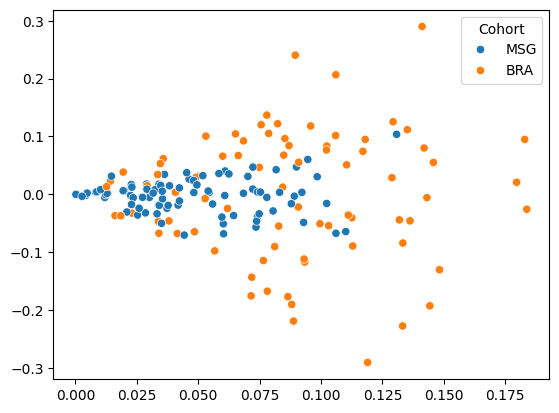

In [19]:
pca = PCA(n_components=2)
pca.fit(CPM)
print(pca.explained_variance_ratio_)
meta = meta.loc[CPM.columns]
meta['Cohort'] = [val[:3] for val in meta['Cohort'].values]
for clinical_feature in meta.columns:
    plt.clf()
    sns.scatterplot(x=pca.components_[0],y=pca.components_[1],hue=meta[clinical_feature])
    plt.savefig('figures/pca_'+clinical_feature.replace('/','+')+'.pdf',format='pdf',bbox_inches='tight')

In [3]:
obodag = GODag("../go-basic.obo")
objanno = Gene2GoReader('../gene2go', taxids=[9606])
ns2assoc = objanno.get_ns2assc()
RS2NT = {GENEID2NT[nt][5]:nt for nt in GENEID2NT}; NT2RS = {nt:GENEID2NT[nt][5] for nt in GENEID2NT}

../go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms
HMS:0:00:36.301792 346,071 annotations, 20,759 genes, 18,733 GOs, 1 taxids READ: ../gene2go 


In [4]:
def run_go(glist,label):
	glist = glist.map(RS2NT).dropna().astype('int')
	goeaobj = GOEnrichmentStudyNS(GENEID2NT.keys(),ns2assoc,obodag,alpha = 0.05,methods = ['fdr_bh'])
	goea_results_all = goeaobj.run_study(glist, prt=None)
	goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
	#plot_results("go.plots/"+label+".png", goea_results_sig)
	return goea_results_sig

In [5]:
DE = []
for de in glob('de/gene*'):
	label = de.split('.')[1]+'_de'
	de = pd.read_csv(de,index_col=0)
	de['Test'] = label
	DE.append(de)

DE = pd.concat(DE)
DE = DE[~DE['pvalue'].isna()]
DE['Q'] = multipletests(DE['pvalue'],method='fdr_bh')[1]

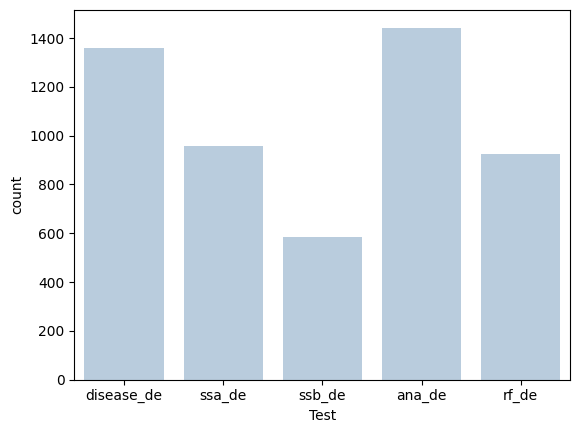

In [36]:
DEq = DE[DE['Q'] < 0.05]
plt.clf()
sns.countplot(DEq,x='Test',color='#b3cde3',order=['disease_de','ssa_de','ssb_de','ana_de','rf_de'])
plt.savefig('figures/de_count.pdf',format='pdf',bbox_inches='tight')

In [7]:
for de in glob('de/gene*'):
    clinical_feature = de.split('/')[1].split('.')[1]+'_de'
    subDE = DE[(DE['Q'] < 0.05) & (DE['Test'] == clinical_feature)].index
    res = run_go(subDE,clinical_feature)
    obodag.draw_lineage([r.goterm for r in res],output='go.plots/'+clinical_feature+'.svg',gml=True,draw_children=False)


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/ana_de.gml
lineage info for terms ['GO:0002376', 'GO:0008150', 'GO:0065007', 'GO:0050789', 'GO:0050794', 'GO:0002682', 'GO:0006955', 'GO:0009987', 'GO:0050896', 'GO:0048518', 'GO:0048583', 'GO:0002684', 'GO:0050776', 'GO:0006952', 'GO:0048584', 'GO:0048522', 'GO:0007165', 'GO:0009607', 'GO:0051239', 'GO:0043207', 'GO:0050778', 'GO:0044419', 'GO:0009605', 'GO:0007166', 'GO:0006950', 'GO:0051707', 'GO:0050865', 'GO:0002694', 'GO:0048519', 'GO:0001775', 'GO:0045321', 'GO:0051249', 'GO:0098542', 'GO:0019222', 'GO:0048523', 'GO:0046649', 'GO:0051240', 'GO:0001817', 'GO:0032101', 'GO:0140546', 'GO:0060255', 'GO:0010646', 'GO:0009966', 'GO:0023051', 'GO:0031323', 'GO:1903037', 'GO:0050863', 'GO:0022407', 'GO:0031347', 'GO:0030155', 'GO:0002250', 'GO:0050867', 'GO:0032501', 'GO:0009893', 'GO:0009889', 'GO:0002696', 'GO:0031326', 'GO:0002253', 'GO:0002764', 'GO:0010556', 'GO:0051251', 'GO:0010604', 'GO:0002683', 'GO:0002697', 'GO:0010468', 'GO:0042221', 'GO:1903039


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/ssb_de.gml
lineage info for terms ['GO:0008150', 'GO:0002376', 'GO:0065007', 'GO:0050789', 'GO:0006955', 'GO:0050794', 'GO:0009987', 'GO:0050896', 'GO:0002682', 'GO:0002684', 'GO:0048518', 'GO:0050776', 'GO:0050778', 'GO:0048584', 'GO:0048583', 'GO:0007165', 'GO:0002250', 'GO:0043207', 'GO:0009607', 'GO:0051239', 'GO:0044419', 'GO:0048522', 'GO:0006952', 'GO:0007166', 'GO:0051707', 'GO:0019222', 'GO:0045321', 'GO:0006950', 'GO:0009605', 'GO:0001775', 'GO:0060255', 'GO:0140546', 'GO:0046649', 'GO:0031323', 'GO:0032501', 'GO:0031326', 'GO:0098542', 'GO:0002252', 'GO:0009889', 'GO:0002764', 'GO:0010556', 'GO:0002253', 'GO:0010468', 'GO:0002768', 'GO:0048519', 'GO:0032101', 'GO:0001817', 'GO:0051240', 'GO:0002757', 'GO:0048523', 'GO:0002697', 'GO:0002429', 'GO:0002831', 'GO:0031347', 'GO:0010646', 'GO:0045087', 'GO:0010033', 'GO:0042221', 'GO:0050851', 'GO:0002694', 'GO:0051049', 'GO:0002699', 'GO:0001819', 'GO:0023051', 'GO:0009966', 'GO:0009893', 'GO:0050865


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/ssa_de.gml
lineage info for terms ['GO:0002376', 'GO:0008150', 'GO:0006955', 'GO:0050789', 'GO:0065007', 'GO:0050794', 'GO:0002682', 'GO:0050896', 'GO:0009987', 'GO:0002684', 'GO:0050776', 'GO:0048518', 'GO:0048583', 'GO:0048584', 'GO:0006952', 'GO:0007165', 'GO:0050778', 'GO:0009607', 'GO:0048522', 'GO:0007166', 'GO:0043207', 'GO:0051239', 'GO:0045321', 'GO:0009605', 'GO:0006950', 'GO:0044419', 'GO:0001775', 'GO:0051707', 'GO:0046649', 'GO:0002250', 'GO:0002694', 'GO:0050865', 'GO:0051249', 'GO:0048519', 'GO:0098542', 'GO:0001817', 'GO:0032501', 'GO:0019222', 'GO:0002764', 'GO:0051240', 'GO:0060255', 'GO:0002253', 'GO:0048523', 'GO:0140546', 'GO:0032101', 'GO:0002768', 'GO:0002757', 'GO:0031323', 'GO:0042110', 'GO:0050863', 'GO:0022407', 'GO:0001819', 'GO:0002696', 'GO:0050867', 'GO:1903037', 'GO:0009893', 'GO:0010646', 'GO:0030155', 'GO:0009966', 'GO:0002252', 'GO:0051251', 'GO:0002697', 'GO:0031347', 'GO:0002429', 'GO:0050670', 'GO:0010468', 'GO:0010556


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/disease_de.gml
lineage info for terms ['GO:0002376', 'GO:0008150', 'GO:0002682', 'GO:0050789', 'GO:0065007', 'GO:0050794', 'GO:0006955', 'GO:0050896', 'GO:0009987', 'GO:0002684', 'GO:0048583', 'GO:0050776', 'GO:0048518', 'GO:0006952', 'GO:0048584', 'GO:0048522', 'GO:0007165', 'GO:0051239', 'GO:0050778', 'GO:0009607', 'GO:0043207', 'GO:0007166', 'GO:0006950', 'GO:0009605', 'GO:0001775', 'GO:0045321', 'GO:0044419', 'GO:0050865', 'GO:0002694', 'GO:0051707', 'GO:0051249', 'GO:0048519', 'GO:0046649', 'GO:0098542', 'GO:0048523', 'GO:0032101', 'GO:0019222', 'GO:0051240', 'GO:0060255', 'GO:0001817', 'GO:0002250', 'GO:0031347', 'GO:0009966', 'GO:0010646', 'GO:0050863', 'GO:0022407', 'GO:0031323', 'GO:0023051', 'GO:0140546', 'GO:1903037', 'GO:0032501', 'GO:0030155', 'GO:0002764', 'GO:0002697', 'GO:0002683', 'GO:0002252', 'GO:0002253', 'GO:0050867', 'GO:0022409', 'GO:0002696', 'GO:0009889', 'GO:1903039', 'GO:0051251', 'GO:0031326', 'GO:0010556', 'GO:0002768', 'GO:008


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/rf_de.gml
lineage info for terms ['GO:0002376', 'GO:0006955', 'GO:0008150', 'GO:0065007', 'GO:0050789', 'GO:0002682', 'GO:0050794', 'GO:0050896', 'GO:0002684', 'GO:0050776', 'GO:0048518', 'GO:0048583', 'GO:0009987', 'GO:0006952', 'GO:0048584', 'GO:0050778', 'GO:0048522', 'GO:0009607', 'GO:0043207', 'GO:0007165', 'GO:0051239', 'GO:0045321', 'GO:0009605', 'GO:0044419', 'GO:0007166', 'GO:0006950', 'GO:0001775', 'GO:0051707', 'GO:0046649', 'GO:0002694', 'GO:0050865', 'GO:0051249', 'GO:0002250', 'GO:0098542', 'GO:0048519', 'GO:0019222', 'GO:0001817', 'GO:0060255', 'GO:0140546', 'GO:0048523', 'GO:0002764', 'GO:0002253', 'GO:0050863', 'GO:0032101', 'GO:0031323', 'GO:0051240', 'GO:0042110', 'GO:0032501', 'GO:0002757', 'GO:0022407', 'GO:0009893', 'GO:0002252', 'GO:1903037', 'GO:0010646', 'GO:0010556', 'GO:0002768', 'GO:0010468', 'GO:0009966', 'GO:0031326', 'GO:0023051', 'GO:0009889', 'GO:0002683', 'GO:0001819', 'GO:0030155', 'GO:0002697', 'GO:0031347', 'GO:0010604'

/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_13028/929265519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subDE['Q'] = -subDE['Q'].apply(np.log10)
/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_13028/929265519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subDE['Color'] = 'tab:gray'
/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_13028/929265519.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

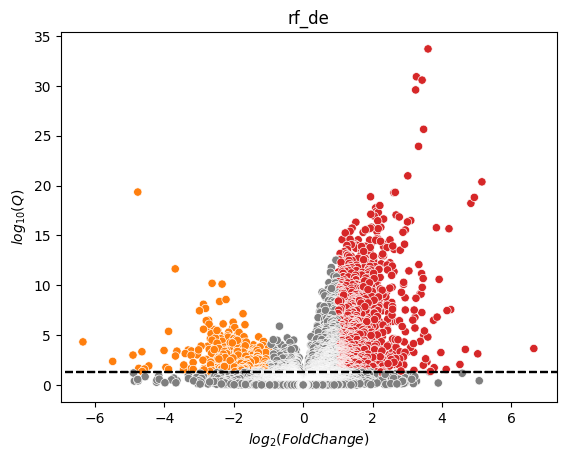

In [29]:
for variable in ['disease_de','ssa_de','ssb_de','ana_de','rf_de']:
    subDE = DE[DE['Test'] == variable]
    subDE['Q'] = -subDE['Q'].apply(np.log10)
    subDE['Color'] = 'tab:gray'
    subDE['Color'][(subDE['Q'] > -np.log10(0.05)) & (subDE['log2FoldChange'] < -1)] = 'tab:orange'
    subDE['Color'][(subDE['Q'] > -np.log10(0.05)) & (subDE['log2FoldChange'] > 1)] = 'tab:red'
    plt.plot([-50,50],[-np.log10(0.05),-np.log10(0.05)],'--',c='k')
    subDE = subDE.dropna()
    sns.scatterplot(data=subDE,x='log2FoldChange',y='Q',c=subDE['Color'])
    plt.xlim(subDE['log2FoldChange'].min()*1.1,subDE['log2FoldChange'].max()*1.1)
    plt.ylabel('$log_{10}(Q)$'); plt.title(variable); plt.xlabel('$log_2(Fold Change)$')
    plt.savefig('figures/volcano_'+variable+'.pdf',format='pdf',bbox_inches='tight')

In [73]:
# echo '##fileformat=VCFv4.1' > res9.vcf
# sed -r 's/,("[^"]*")*/\t\1/g' res9.csv | cut -f2- >> res9.vcf
# bedtools intersect -wao -a res9.vcf -b all_ens.bed > res9.gen
res9 = pd.read_csv('res9.csv',index_col=0)
res9['Gene'] = False
res9gen = pd.read_csv('res9.gen',sep='\t',header=None)
G = {}
for variable in ['SjD Diagnosis','SSA','SSB','ANA','RF']:
    G[variable] = []
    res9var = res9[res9['Test'] == variable]
    if variable == 'SjD Diagnosis':
        print((res9var['#CHROM']+':'+res9var.POS.astype('str')+'-'+(res9var.POS+1).astype('str')).to_list())
    for row in res9var.iterrows():
        res9gensub = res9gen[(res9gen[0] == row[1]['#CHROM']) & (res9gen[1] == row[1]['POS'])]
        res9gensub = res9gensub[(res9gensub[189] == 'protein_coding') | (res9gensub[189] == 'processed_transcript')]
        gene_names = res9gensub[185].value_counts().index
        gene_names = list(set(['-'.join(gene_name.split('-')[:-1]) for gene_name in gene_names]))
        gene_names = [gene_name for gene_name in gene_names if 'CHM13_' not in gene_name and '.' not in gene_name]
        if len(gene_names) == 1:
            res9['Gene'][(res9['#CHROM'] == row[1]['#CHROM']) & (res9['POS'] == row[1]['POS'])] = gene_names[0]
        G[variable] += gene_names

['chr1:156883059-156883060', 'chr1:156933180-156933181', 'chr2:208141029-208141030', 'chr5:55861694-55861695', 'chr6:36575004-36575005', 'chr6:150647755-150647756', 'chr7:143836861-143836862', 'chr8:24669147-24669148', 'chr8:24669151-24669152', 'chr8:24669156-24669157', 'chr8:24669166-24669167', 'chr8:24669169-24669170', 'chr8:24669170-24669171', 'chr8:24669174-24669175', 'chr8:24669182-24669183', 'chr8:24680958-24680959', 'chr8:28300498-28300499', 'chr8:28300521-28300522', 'chr8:30958102-30958103', 'chr8:127078565-127078566', 'chr11:60420686-60420687', 'chr15:83066881-83066882', 'chr16:29219882-29219883', 'chr19:8057291-8057292', 'chr19:53516994-53516995', 'chr20:1651447-1651448']


/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_14570/2949398682.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res9['Gene'][(res9['#CHROM'] == row[1]['#CHROM']) & (res9['POS'] == row[1]['POS'])] = gene_names[0]
/var/folders/5y/4ldrp3j959b0fcn9pvx95rjrqrkdq2/T/ipykernel_14570/2949398682.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'FCRL2' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  res9['Gene'][(res9['#CHROM'] == row[1]['#CHROM']) & (res9['POS'] == row[1]['POS'])] = gene_names[0]


In [98]:
bSNs = CPM.columns[CPM.columns.str.contains('MSG_')]
scSNs = ['MSG_'+SN for SN in ['3598','3560','3247','3604','3603','3606','3559','3561','3564','3592','3596','3618','3621','3622','3637','3607','3614','3617','3556','3623','3630','3632','3633','3437','3546','3563','3717','3555','3750','3751','3740','3545','3741','3553','3738','3330','3629','3631','3636','3635','3735','3743','3570','3600','3608']]
shared_SNs = set(bSNs).intersection(set(scSNs))
shared_SNs = [SN for SN in shared_SNs if SN in res9.columns]
shared_SNs = res9[shared_SNs]
shared_SNs.index = shared_SNs.index.map(res9['Gene'].to_dict())
shared_SNs.columns = [split[1] for split in shared_SNs.columns.str.split('_')]
shared_SNs.loc['HLA-DQA1'].iloc[0].to_dict()

{'3604': False,
 '3592': False,
 '3743': False,
 '3555': True,
 '3560': True,
 '3563': True,
 '3629': True,
 '3564': False,
 '3607': False,
 '3632': False,
 '3545': False,
 '3633': False,
 '3596': False,
 '3717': False,
 '3437': False,
 '3738': True,
 '3637': False,
 '3636': False,
 '3553': False,
 '3556': False,
 '3546': False}

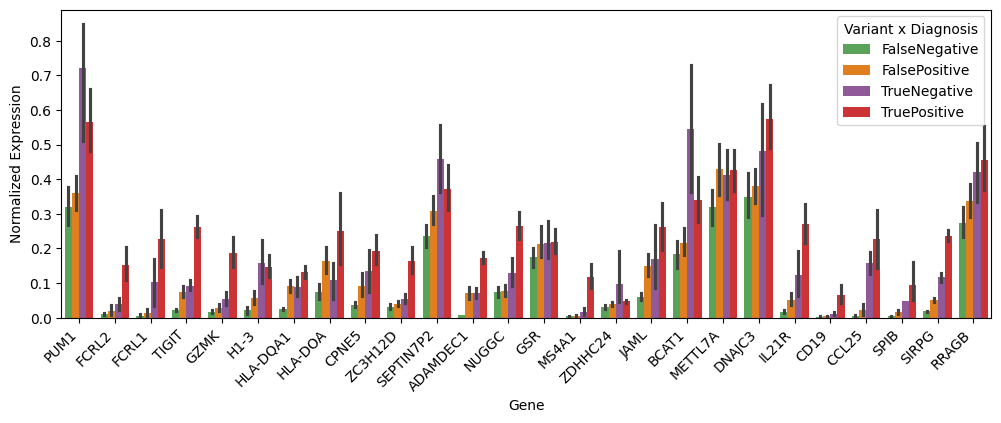

In [83]:
DF = []
res9 = res9[(res9['Gene'] != 'C12orf66') & (res9['Gene'] != 'ADAMTS7P4')]
for i in res9.iterrows():
    if i[1]['Gene'] and ('orf' not in i[1]['Gene']):
        boolset = i[1][res9.columns[res9.columns.str.contains('BRA')+res9.columns.str.contains('MSG')]]
        g = CPM[boolset.index].loc[i[1]['Gene']]
        df = pd.DataFrame([g,boolset],index = ['Expression (CPM)','Has Variant']).T
        df['Gene'] = i[1]['Gene']
        df['Normalized Expression'] = df['Expression (CPM)'] / df['Expression (CPM)'].max()
        DF.append(df)

DF = pd.concat(DF)
DF['SjD Diagnosis'] = DF.index.map(meta['SjD Diagnosis'].to_dict())
DF['Variant x Diagnosis'] = DF['Has Variant'].astype('str') + DF['SjD Diagnosis']
plt.figure(figsize=(12,4))
sns.barplot(data=DF,x='Gene',y='Normalized Expression',hue='Variant x Diagnosis',hue_order=sorted(DF['Variant x Diagnosis'].value_counts().index),palette=['#4daf4a','#ff7f00','#984ea3','#e41a1c'])
plt.xticks(ha='right',rotation=45)
plt.savefig('figures/eQTL_barchart.pdf',format='pdf',bbox_inches='tight')

In [84]:
for var in ['SjD Diagnosis','SSA','SSB','ANA','RF']:
    res = run_go(pd.Index(G[var]),var+'_GATK9')
    obodag.draw_lineage([r.goterm for r in res],output='go.plots/'+var+'_GATK9.svg',gml=True,draw_children=False)


Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/SjD Diagnosis_GATK9.gml
lineage info for terms ['GO:0008150', 'GO:0002376', 'GO:0042113', 'GO:0006955', 'GO:0050896', 'GO:0009897', 'GO:0110165', 'GO:0005575', 'GO:0098552'] written to go.plots/SjD Diagnosis_GATK9.svg



Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/SSA_GATK9.gml
lineage info for terms [] written to go.plots/SSA_GATK9.svg



Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/SSB_GATK9.gml
lineage info for terms [] written to go.plots/SSB_GATK9.svg



Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/ANA_GATK9.gml
lineage info for terms ['GO:0050863', 'GO:1903037', 'GO:0022407', 'GO:0051249', 'GO:0002694', 'GO:0050865'] written to go.plots/ANA_GATK9.svg



Load BP Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,580 of 59,542 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 33% 19,647 of 59,542 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 31% 18,311 of 59,542 population items found in association


GML graph written to go.plots/RF_GATK9.gml
lineage info for terms ['GO:0110165', 'GO:0005575', 'GO:0000323', 'GO:0005764', 'GO:0005773', 'GO:0043229', 'GO:0043226', 'GO:0043231'] written to go.plots/RF_GATK9.svg
